<a href="https://colab.research.google.com/github/kecosz/EcohNet_py/blob/main/ecohnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EcohNet
9/28/2023  
version 0.12  

The results of the original version were obtained using NumPy 1.23.5 and statsmodels 0.13.5. However, due to package conflicts in the Google Colab environment, we have removed these version constraints.

### Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#!cat /proc/cpuinfo

### Clone EcohNet_py repository

In [3]:
!git clone https://github.com/kecosz/EcohNet_py.git

Cloning into 'EcohNet_py'...
remote: Enumerating objects: 415, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 415 (delta 3), reused 1 (delta 1), pack-reused 407 (from 1)
Receiving objects: 100% (415/415), 2.77 MiB | 21.14 MiB/s, done.
Resolving deltas: 100% (216/216), done.


### Setup environment

In [4]:
import sys
# change both paths
REPO_PATH='/content/EcohNet_py/src'
%cd EcohNet_py/
sys.path.append(REPO_PATH)
!pip install -e .

/content/EcohNet_py
Obtaining file:///content/EcohNet_py
  Preparing metadata (setup.py) ... done
  Running setup.py develop for EcohNet


#### Setup modules

In [5]:
from __future__ import annotations
import os
import re
import pprint
import time
import itertools
from pathlib import Path

import dill
from tqdm.autonotebook import tqdm
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.nonparametric.kde import KDEUnivariate

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.ticker as ticker
from matplotlib import gridspec
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns
from graphviz import Digraph
from IPython.core.display import HTML

from ecohnet.utils.preprocess import std
from ecohnet import RCmat, RCprd, RCsetup, RCcore, RCall
matplotlib.rcParams['figure.dpi'] = 100

/tmp/ipython-input-3839424275.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


#### Set import and export folder
Below, please specify the folder where you placed your data (csv) and the folder you want to export the results.

In [6]:
PROJECT_ROOT = Path("/content/drive/MyDrive")
DATA_DIR = PROJECT_ROOT / "data"
OUT_DIR = PROJECT_ROOT / "colab_export"

## Analysis

Analyse a sample data and export the result as a csv.
To analyze your own data, please modify the file name.

The time series of one variable must be arranged in columns.

In [7]:
data_df = pd.read_csv(DATA_DIR / "ecohnet_sample_data.csv", header=0) - 1000
print(data_df.head(4))

            x1           x2          x3           x4          x5          x6  \
0   697.812711  -420.836811 -768.820416  -274.395424 -500.529280 -996.744236   
1  1390.917188  1193.450022 -121.509818  1921.964750  614.181526 -996.012520   
2  -412.256008   154.471741 -468.637600  -691.998377 -529.094489 -995.384808   
3 -1000.000000 -1000.000000 -611.948457  2505.004708 -290.071835 -994.861907   

           x7          x8  
0 -998.239318 -998.483425  
1 -998.267949 -998.387548  
2 -998.658359 -998.418861  
3 -997.411564 -998.418861  


### Causal relationships

Run the variable selection processes,
followed by the evaluation of unique predictive skills.

In [8]:
data = np.array(data_df)
start_time = time.time()
length = len(data[0])
da = std(data)
procs = 100 # <- number of prediction processes used for evaluation: set to 1000 or more for stable results
rcc: list[
    tuple[tuple[float, KDEUnivariate], np.ndarray, np.ndarray, np.ndarray]
] = []
with tqdm(range(length), desc="RCcore") as pbar:
    for tgti in pbar:
        RCsetup((0.95, 0.99, 0.001, 8), procs)
        rcc.append(RCcore(da, tgti, progress_bar=pbar))
rcmat = RCmat(da, rcc)
print(f"elapsed: {time.time() - start_time} s")

RCcore:   0%|          | 0/8 [00:00<?, ?it/s]

RCmat:   0%|          | 0/8 [00:00<?, ?it/s]

elapsed: 260.0727343559265 s


In [9]:
data[0]

array([ 697.81271052, -420.83681056, -768.82041613, -274.39542449,
       -500.52928014, -996.74423588, -998.23931831, -998.48342491])

Now, a matrix of unique predictive skills is obtained. In the following, it is saved as "upsmatrix.csv" in the session folder.

In [10]:
columns = [column + "->" for column in data_df.columns]
index = ["->" + column for column in data_df.columns]
upsmatrix = pd.DataFrame.from_records(rcmat[0], index=index, columns=columns)
print(upsmatrix)
upsmatrix.to_csv(OUT_DIR / "upsmatrix.csv")

          x1->      x2->      x3->      x4->      x5->      x6->      x7->  \
->x1  0.052356  0.000000  0.000000  0.000000  0.007625  0.034540  0.000000   
->x2  0.002340 -0.013009  0.005644  0.007962  0.000000  0.011978  0.000000   
->x3  0.001444  0.000000  0.008957  0.000000  0.000000 -0.002627  0.000000   
->x4  0.000000  0.000000  0.009476 -0.000069  0.000000  0.040881 -0.008885   
->x5  0.000000  0.000000  0.000000  0.000000 -0.001739  0.048090  0.000000   
->x6  0.000000  0.000000  0.000000  0.000000  0.000000  0.155166  0.000000   
->x7  0.023109  0.000000  0.000000  0.000000  0.000000  0.022251 -0.007303   
->x8  0.000000  0.000000  0.000000  0.000000  0.000000  0.057739  0.000000   

          x8->  
->x1  0.000000  
->x2  0.000000  
->x3  0.014729  
->x4  0.000000  
->x5  0.000000  
->x6  0.000000  
->x7  0.000000  
->x8 -0.015641  


Download the csv file locally:

In [11]:
from google.colab import files
files.download(OUT_DIR / 'upsmatrix.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The second element of `rcmat` represents, in matrix form, the proportion of trials for which the addition of the variables in row did not improve the prediction, and can be used as a criterion for adopting causal relationships.

In [12]:
pd.DataFrame.from_records(rcmat[1], index=index, columns=columns)

,x1->,x2->,x3->,x4->,x5->,x6->,x7->,x8->
->x1,0.216253,1.000000,1.000000,1.000000,0.477344,0.307288,1.000000,1.000000
->x2,0.491554,0.633698,0.462694,0.442814,1.000000,0.409085,1.000000,1.000000
->x3,0.504659,1.000000,0.454174,1.000000,1.000000,0.533571,1.000000,0.417494
->x4,1.000000,1.000000,0.443083,0.521662,1.000000,0.204670,0.596624,1.000000
->x5,1.000000,1.000000,1.000000,1.000000,0.529787,0.183296,1.000000,1.000000
->x6,1.000000,1.000000,1.000000,1.000000,1.000000,0.098135,1.000000,1.000000
->x7,0.161393,1.000000,1.000000,1.000000,1.000000,0.168499,0.641755,1.000000
->x8,1.000000,1.000000,1.000000,1.000000,1.000000,0.131582,1.000000,0.662879


#### Plot upsmatrix as a heatmap

In [13]:
labels = data_df.columns.to_list()[0:]

# helper functions for plot heatmap using mathematica's colormap
def _parse_colorlist(text:str) -> list[list[float]]:
    "parse text of color list, exported mathematica"
    pattern = r"(?P<num>\d+\.\d+)(?:,|])"
    colors = []
    color = []
    for match in re.finditer(pattern, text):
        value_text = match.group('num')
        value = float(value_text)
        color.append(value)
        if len(color) == 3:
            colors.append(color)
            color = []
    return colors

def _get_wolfram_lake_color() -> np.ndarray:
    "load LakeColor exported mathematica"
    file_path = Path("/content/EcohNet_py/external/wolfram/LakeColors.txt")
    assert file_path.exists()
    assert file_path.is_file()
    with open(file_path) as f:
        text = f.read()
    colorlist =  _parse_colorlist(text)
    return np.array(colorlist)

def get_cmap_wolfram_Lake() -> LinearSegmentedColormap:
    "Colormap for matplotlib of LakeColor exported mathematica"
    colors = _get_wolfram_lake_color()
    return LinearSegmentedColormap.from_list("Lake", colors, N=len(colors))


def get_two_range_cmap(name: str='wolfram_lake'):
    "colormap with two regions"
    if name=='wolfram_lake':
        higher = _get_wolfram_lake_color()
        lower = np.array([[0,0,0]] * len(higher))
    else:
        higher = plt.colormaps.get(name)(np.linspace(0, 1, 256))
        lower = np.array([[0,0,0,1]] * len(higher))

    colors = np.vstack((lower, higher))
    cmap = LinearSegmentedColormap.from_list("custom", colors, N=len(colors))
    return cmap

# helper class for plot customized color map
class PowerAndLinearNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        higher = np.clip(value, self.vcenter, None)
        higher = 0.6 * (1 - np.sqrt(higher/self.vmax))
        higher = higher / 2 + 1 / 2
        higher = np.clip(higher, 0.5, 1.0)
        lower = np.clip(value, None, self.vcenter)
        lower = np.interp(lower, [self.vmin, self.vcenter], [0., 0.5])

        ret = higher * (value >= self.vcenter) + lower * (value < self.vcenter)
        ret= np.clip(ret, 0.0, 1.0)
        return ret

# helper class for plot customized color map
class PowerNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, clip=False):
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        ret = 0.6 * (1 - np.sqrt(value/self.vmax))
        return ret

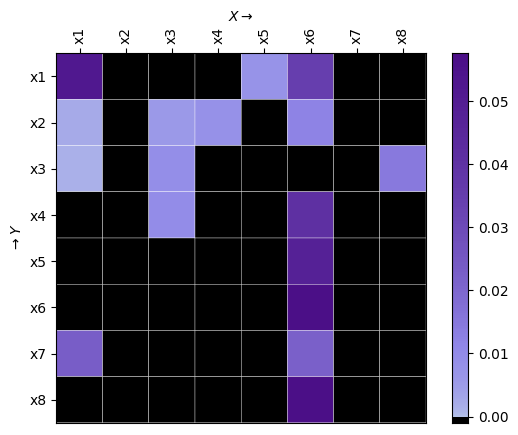

In [14]:
# plot upsmatrix
fig = plt.figure()
spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[25,1])
spec.update(wspace=0.025, hspace=0.05)
# color setting
mx = sorted(abs(rcmat[0]).flatten())[-2]
vmin = rcmat[0].min()
colornorm = PowerAndLinearNormalize(vmin=vmin, vcenter=1e-8, vmax=mx)
cmap = get_two_range_cmap(name='wolfram_lake')
# plot heatmap
ax = fig.add_subplot(spec[0])
aximg = ax.pcolor(rcmat[0], norm=colornorm, cmap=cmap, edgecolors='white')
ax.invert_yaxis()
ax.set_aspect("equal")
# labels
ax.set_xlabel(r"$X\rightarrow$")
ax.xaxis.set_label_position('top')
ax.set_ylabel(r"$\rightarrow Y$")
# ticks
tick_l = [i+1/2 for i in range(len(rcmat[0]))]
ax.set(xticks=tick_l, yticks =tick_l)
ax.set_xticklabels(labels, rotation=90)
ax.xaxis.tick_top()
ax.set_yticklabels(labels)
plt.subplots_adjust(right=0.8)
# plot colorbar
vmin = -0.001
vmax = mx
X, Y = np.mgrid[0:1:0.5, vmin:vmax:(vmax-vmin)/512]
ax = fig.add_subplot(spec[1])
ax.yaxis.tick_right()
ax.contourf(X, Y, Y, norm=colornorm, cmap=cmap, levels=512)
ax.get_xaxis().set_visible(False)
plt.show()

### Visualize causal network

In [15]:
thlevel = 0.002
mm = rcmat[0].copy()
mm[rcmat[0] < thlevel] = 0
# edges above threshold
pos = list(zip(*np.where(mm>0)))
# weights of pos
str_ = mm[mm>0]
# labels having edge
lis = [labels[p] for p in set(v for edge in pos for v in edge)]

cmap = get_cmap_wolfram_Lake()
links_int = []
for p, st in zip(pos, str_):
    # thickness
    thickness_coef = 0.8
    if st > 0.01:
        thickness = 4 * thickness_coef
    elif st > 0.005:
        thickness = 2 * thickness_coef
    else:
        thickness = 1 * thickness_coef
    rgba = cmap(0.6*(1-(st/mx)**0.5))
    color = colors.rgb2hex(rgba)
    link = {"src": str(p[0]), "dst": str(p[1]), "thickness": str(thickness), "color": color}
    links_int.append(link)

dg = Digraph(
    format='png',
    engine="dot",
    graph_attr={
        "ranksep": "0.7",
        "splines": "spline",
        "outputorder": "edgesfirst",
        "margin": "0.2"})

dg.attr('node', shape='circle')
for i, label in enumerate(labels):
    dg.node(str(i), label=f"\n\n{label}", fontname="Arial", shape="circle", fixedsize="true",width="0.1", style="filled",fillcolor="#a3b4cc", fontsize="12")
for link in links_int:
    dg.edge(link['dst'], link['src'],
    style="solid",
    color=link["color"],
    penwidth=link['thickness'],
    arrowsize="0.4")

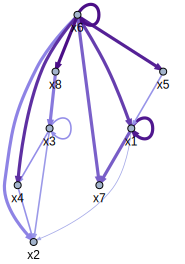

In [16]:
%%capture --no-stdout --no-display cap
# hide stderr (captured into variable 'cap')
dg.render()
dg

## Prediction

One-step-ahead prediction sequences using the optimal sets of variables is obtained by the following function.

In [17]:
rcprd = RCprd(da, rcc)

RCprd:   0%|          | 0/8 [00:00<?, ?it/s]

The following codes visualize the predicted (red lines and gray shading) and actual (blue lines) values.

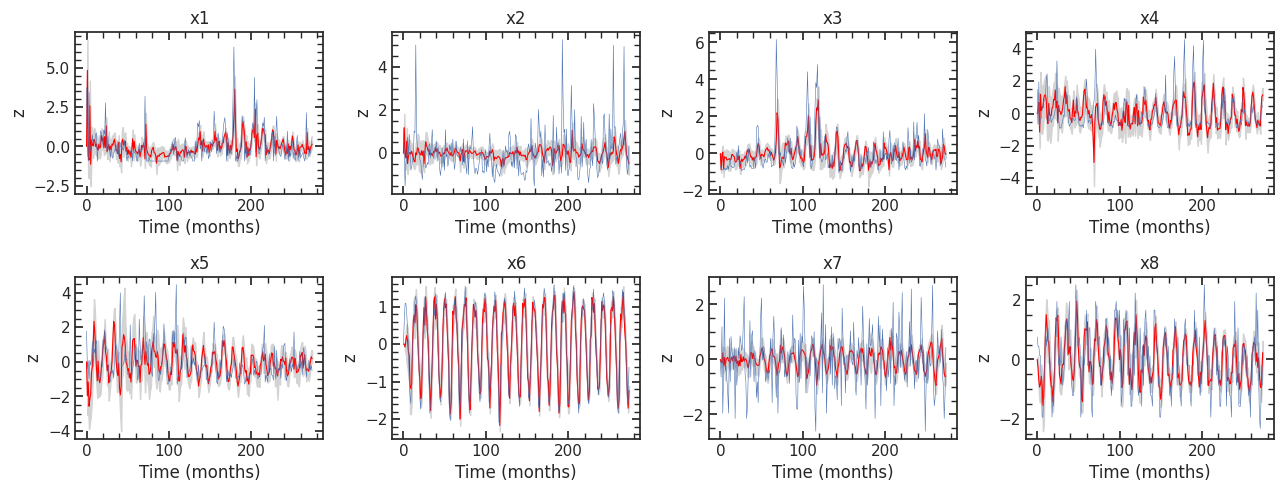

In [18]:
labels = data_df.columns.to_list()[0:]
sns.set_theme(style="ticks")
fig, axes = plt.subplots(5,4, figsize=(13,12))
for i, ax in enumerate(itertools.chain.from_iterable(axes)):
    if i >= len(rcprd):
        fig.delaxes(ax)
        continue
    ax.set_title(labels[i])
    # ticks
    ax.tick_params(which='both', top=True, bottom=True, left=True, right=True, direction='in')
    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    # labels
    ax.set_xlabel("Time (months)")
    ax.set_ylabel("z")
    ys = np.transpose(rcprd[i][1])
    x = np.arange(len(ys[0]))
    sns.lineplot(ys[1], color='red', ax=ax, linewidth=0.8)
    ax.fill_between(x,ys[0],ys[2], color='lightgray')

    target = rcprd[i][2]
    sns.lineplot(target, ax=ax, linewidth=0.4)
plt.tight_layout()
plt.show()
# fig.savefig("timeseries.png")

In [19]:
# spearman rank correlation
preds = np.array([[quantiles[1] for quantiles in a_rcprd[1]] for a_rcprd in rcprd])
ys = np.array([a_rcprd[2] for a_rcprd in rcprd])
spearmancorr = [stats.spearmanr(pred, y).statistic for pred, y in zip(preds, ys)] # type: ignore

In [ ]:
# 1
rcprd_medians = np.array([rcprd_a[0][0] for rcprd_a in rcprd])
sns.set_theme(style="ticks")
fig = plt.figure(figsize=(15,20))
ax = fig.add_subplot(2,1,1)
sns.barplot(x=rcprd_medians,y=labels,ax=ax, color='orange', edgecolor=".1")
ax.xaxis.grid()
ax.tick_params(labelsize=18)
ax.set_xlabel(r"$\rho_{\Omega}$", fontsize=18)
ax.set_title("(a)", x=-0.25, fontsize=24)
# 2
ax = fig.add_subplot(2,1,2)
sns.barplot(x=spearmancorr,y=labels,ax=ax, color='orange', edgecolor=".1")
ax.xaxis.grid()
ax.set_xlim(0,1)
ax.tick_params(labelsize=18)
ax.set_xlabel("Spearman rank correlation", fontsize=18)
ax.set_title("(b)", x=-0.25, fontsize=24)

plt.show()

### Validation with chaotic time series data

In [21]:
# Parameters
nc = 40
dt = 0.001
num_steps = 50000
random_scale = 0.5

# Lorenz system function
def lorenz(state):
    x, y, z = state
    dx = -16 * (x - y)
    dy = -x * z + nc * x - y
    dz = x * y - 4 * z
    return np.array([x, y, z]) + np.array([dx, dy, dz]) * dt + np.random.uniform(-1, 1, 3) * random_scale

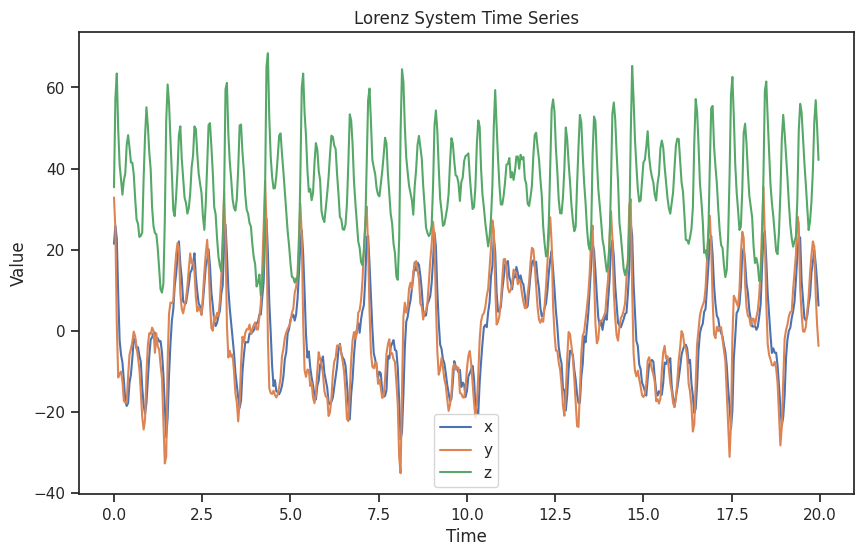

In [22]:
# Generate data
initial_state = np.array([0.1, 0.1, 0.1])
lorts = np.zeros((num_steps + 1, 3))
lorts[0] = initial_state

for i in range(num_steps):
    lorts[i + 1] = lorenz(lorts[i])

# Extract last 20000 steps and downsample
data = lorts[-20000::40]

# Plot data as time series
time_i = np.arange(data.shape[0]) * dt * 40

plt.figure(figsize=(10, 6))
plt.plot(time_i, data[:, 0], label='x')
plt.plot(time_i, data[:, 1], label='y')
plt.plot(time_i, data[:, 2], label='z')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Lorenz System Time Series')
plt.legend()
plt.show()

In [ ]:
# Generate new data with random initial conditions
initial_state_random = np.random.random(3)
lorts_random = np.zeros((num_steps + 1, 3))
lorts_random[0] = initial_state_random

for i in range(num_steps):
    lorts_random[i + 1] = lorenz(lorts_random[i])

# Extract last 40000 steps at 80-point intervals (500 points)
data_random = lorts_random[-40000::80]
data = data_random

# EcohNet
start_time = time.time()
length = len(data[0])
da = std(data)
procs = 1000 # <- number of prediction processes used for evaluation: set to 1000 or more for stable results
rcc: list[
    tuple[tuple[float, KDEUnivariate], np.ndarray, np.ndarray, np.ndarray]
] = []
with tqdm(range(length), desc="RCcore") as pbar:
    for tgti in pbar:
        RCsetup((0.95, 0.99, 0.001, 8), procs)
        rcc.append(RCcore(da, tgti, progress_bar=pbar))
rcmat = RCmat(da, rcc)
print(f"elapsed: {time.time() - start_time} s")
print("rcmat:")
rcmat

RCcore:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Second matrix data (example of different data)
matrix_correct = np.array([
    [1, 1, 0],
    [1, 1, 1],
    [1, 1, 1]
])

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display the first heatmap
im1 = axs[0].imshow(rcmat[0], cmap='viridis', aspect='auto')
fig.colorbar(im1, ax=axs[0])  # Display color bar for the first heatmap
axs[0].set_title('EcohNet')
axs[0].set_xlabel('Column')
axs[0].set_ylabel('Row')

# Display the second heatmap
im2 = axs[1].imshow(matrix_correct, cmap='viridis', aspect='auto')
fig.colorbar(im2, ax=axs[1])  # Display color bar for the second heatmap
axs[1].set_title('Actual')
axs[1].set_xlabel('Column')
axs[1].set_ylabel('Row')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
rcprd = RCprd(data, rcc)

In [ ]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for z in range(3):
    data1 = [i[1] for i in rcprd[z][1]]
    data2 = rcprd[z][2]

    # Take the last 50 points
    data1_last50 = data1[-50:]
    data2_last50 = data2[-50:]

    # Plot the data
    axes[z].plot(data1_last50, label='Predicted')
    axes[z].plot(data2_last50, label='Actual')
    axes[z].legend()
    axes[z].set_title(f'Plot {z+1}')

# Display the plot
plt.tight_layout()
plt.show()